In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import sys
sys.path.append('/content/drive/MyDrive/Project/Unet_Network')
sys.path.append('/content/drive/MyDrive/Project/Unet_Network/Unet/')
'''
sys.path.insert(0,'/content/drive/MyDrive/Project/Unet_Network/Unet_network/')
sys.path.insert(0,'/content/drive/MyDrive/unet_network/Unet/')
'''
#import Unet
# from model import UNET
from model_2 import UNet11
from utils import(
     load_checkpoint,
     save_checkpoint,
     get_loaders,
     check_accuracy,
     save_predictions_as_imgs,
)
#hyperparameter
LERNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE= 16
NUM_EPOCHS=10
NUM_WORKERS = 2
IMAGE_HEIGHT= 256
IMAGE_WIDTH= 256
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR ='/content/drive/MyDrive/Project/data/train/images/'
TRIN_MASK_DIR ='/content/drive/MyDrive/Project/data/train/mask/'
VAL_IMG_DIR = '/content/drive/MyDrive/Project/data/valid/images/'
VAL_MASK_DIR = '/content/drive/MyDrive/Project/data/valid/mask/'

In [ ]:
!pip install tensorflow==1.15
!pip install keras==2.2.5
# !pip install skimage==0.16.2
# !pip install opencv-python==4.1.2
!pip install h5py==2.8.0
# !pip install tqdm
# !pip install pandas==0.25.3
!pip install numpy==1.17.5

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
# import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
import h5py

from sklearn.model_selection import train_test_split

from PIL import Image

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation
from keras import layers
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
# from tensorflow.keras.metrics import MeanIoU
import keras
from keras import backend as K

seed = 56

# Defining Custom Loss functions and accuracy Metric.

In [ ]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Load data

In [ ]:
imagesPath = "/content/drive/MyDrive/Project/data/images"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(imagesPath) if isfile(join(imagesPath, f))]

In [ ]:
print(onlyfiles)

['Copy of n-11-s-48.bmp', 'Copy of n-11-d-160.bmp', 'Copy of n-11-s-88.bmp', 'Copy of n-11-s-68.bmp', 'Copy of n-11-s-28.bmp', 'Copy of n-11-s-108.bmp', 'Copy of n-11-s-128.bmp', 'Copy of n-11-d-180.bmp', 'Copy of n-11-s-168.bmp', 'Copy of n-11-s-148.bmp', 'Copy of n-11-d-120.bmp', 'Copy of n-07-s-186.bmp', 'Copy of n-11-d-100.bmp', 'Copy of n-11-d-20.bmp', 'Copy of n-11-d-40.bmp', 'Copy of n-07-s-146.bmp', 'Copy of n-07-s-166.bmp', 'Copy of n-11-d-140.bmp', 'Copy of n-11-d-80.bmp', 'Copy of n-11-d-60.bmp', 'Copy of n-07-s-126.bmp', 'Copy of n-07-d-140.bmp', 'Copy of n-07-d-200.bmp', 'Copy of n-07-s-106.bmp', 'Copy of n-07-s-66.bmp', 'Copy of n-07-d-180.bmp', 'Copy of n-07-s-46.bmp', 'Copy of n-07-d-160.bmp', 'Copy of n-07-s-86.bmp', 'Copy of n-07-d-220.bmp', 'Copy of n-07-d-80.bmp', 'Copy of n-06-s-68.bmp', 'Copy of n-06-s-128.bmp', 'Copy of n-07-d-40.bmp', 'Copy of n-06-s-148.bmp', 'Copy of n-07-d-60.bmp', 'Copy of n-07-d-100.bmp', 'Copy of n-07-d-120.bmp', 'Copy of n-06-s-108.bmp', 

In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Project/data/

/content/drive/MyDrive/Project/data


In [ ]:
"images/" + onlyfiles[0]

'images/Copy of n-11-s-48.bmp'

In [ ]:
imgs = []
for i in range(100):
    imgs.append(cv2.resize(cv2.imread("images/" + onlyfiles[i]) , (128,128), interpolation = cv2.INTER_AREA))

In [ ]:
img = cv2.resize(cv2.imread("images/"+"Copy of n-11-s-48.bmp"), (128,128), interpolation = cv2.INTER_AREA)



In [ ]:
imgs = np.array(imgs)
my_imgs = []
for img in imgs:
  # i = i+1
  # img = cv2.resize(cv2.imread("/content/drive/MyDrive/MorphoDataset/"+str(i)+".jpg"), (256,256), interpolation = cv2.INTER_AREA)
  img = Image.fromarray(img)
  Icmyk = img.convert('CMYK')
  img = np.array(Icmyk)[:,:,1]
  # expand masks dimension
  # img = np.array(np.expand_dims(img, -1))

  img2 = np.zeros((128, 128, 3))
  img2[:,:,0] = img
  img2[:,:,1] = img
  img2[:,:,2] = img
  img = img2
  my_imgs.append(img)


In [ ]:
maskPath = "/content/drive/MyDrive/Project/data/mask"
from os import listdir
from os.path import isfile, join
maskFiles = [f for f in listdir(maskPath) if isfile(join(maskPath, f))]

In [ ]:
masks = []
for i in range(100):
    # masks.append(cv2.resize(cv2.imread("mask/" + maskFiles[i], 0), (256,256), interpolation = cv2.INTER_AREA))
    img = cv2.resize(cv2.imread("mask/" + maskFiles[i], 0), (128,128), interpolation = cv2.INTER_AREA)
    masks.append(np.array(np.expand_dims(img, -1)))


In [ ]:
my_masks = np.array(masks)
my_imgs = np.array(my_imgs)
print(my_imgs.shape)
print(my_masks.shape)

(100, 128, 128, 3)
(100, 128, 128, 1)


#Split data

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(my_imgs, my_masks, test_size=0.2, random_state=seed)
# del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(80, 256, 256, 3)
(80, 256, 256, 1)
TEST SET
(20, 256, 256, 3)
(20, 256, 256, 1)


#Define Model

In [ ]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

#Hyper Parameters

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

#Initializing Callbacks

In [ ]:
# from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
model_path = "skeyenet/Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

#Compiling Model

In [ ]:
# opt = keras.optimizers.adam(LEARNING_RATE)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [ ]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    # callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                       )

NameError: ignored

In [ ]:
model.save("skeyenet/Models/road_mapper_final.h5")

# Data Augmentation

In [ ]:
X, Y =[], []

In [ ]:
for i, img in enumerate(my_imgs):
  X.append(np.array(img, dtype = np.float32))
  Y.append(np.array(my_masks[i], dtype = np.float32))

  #flip horizontally
  flip_hr=iaa.Fliplr(p=1.0)
  X.append(np.array(flip_hr.augment_image(img), dtype = np.float32))
  Y.append(np.array(flip_hr.augment_image(my_masks[i]), dtype = np.float32))

  #Flip vertically
  flip_vr=iaa.Flipud(p=1.0)
  X.append(np.array(flip_vr.augment_image(img), dtype = np.float32))
  Y.append(np.array(flip_vr.augment_image(my_masks[i]), dtype = np.float32))

  # Contrast
  contrast=iaa.GammaContrast(gamma=0.9)
  X.append(np.array(contrast.augment_image(img), dtype = np.float32))
  Y.append(np.array(my_masks[i], dtype = np.float32))

  # Rotate

  rotate = iaa.Rotate((-45, 45))
  X.append(np.array(rotate.augment_image(img), dtype = np.float32))
  Y.append(np.array(rotate.augment_image(my_masks[i]), dtype = np.float32))

  # ScaleX

  scale = iaa.ScaleX((0.5, 1.5))
  X.append(np.array(scale.augment_image(img), dtype = np.float32))
  Y.append(np.array(scale.augment_image(my_masks[i]), dtype = np.float32))

  # # CropToFixedSize
  # crop = iaa.CropToFixedSize(width=100, height=100)
  # X.append(np.array(crop.augment_image(img), dtype = np.float32))
  # Y.append(np.array(crop.augment_image(my_masks[i]), dtype = np.float32))


In [ ]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(600, 128, 128, 3)
(600, 128, 128, 1)


In [ ]:
!pwd


/content/drive/MyDrive/Project/data


In [ ]:
# model_base = load_model("road_mapper_final.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

# if we want to fine tune the model we should use this code with loss function
model = load_model("../tail_detection_model.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

# model = load_model("road_mapper_final.h5", compile=False)

In [ ]:
# here is loop for freezing particular layer (dense_10 in this example)
for i, layer in enumerate(model.layers):
  if i<58:
    layer.trainable = False

In [ ]:
model.fit(X, Y, epochs=3, batch_size=5, verbose=1)

Epoch 1/3
120/120 [==============================] - 7s 21ms/step - loss: -0.8956 - iou_coef: 23.7254
Epoch 2/3
120/120 [==============================] - 3s 21ms/step - loss: -0.9119 - iou_coef: 25.4771
Epoch 3/3
120/120 [==============================] - 3s 22ms/step - loss: -0.9161 - iou_coef: 26.1176


In [ ]:
model.save("tail_detection_model.h5")

In [ ]:
# modelpath = "tail_detection_model.h5"
model = load_model("tail_detection_model.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
# modelpath = "/content/drive/MyDrive/MATLAB/skeyenet/Models/road_mapper_final.h5"
# model = keras.models.load_model(modelpath)

In [ ]:
# --------------------------- TEST ---------------------------
# x_test = cv2.resize(cv2.imread("/content/drive/MyDrive/Project/dataset/16.jpg"), (256,256), interpolation = cv2.INTER_AREA)
x_test = cv2.resize(cv2.imread("/content/drive/MyDrive/Project/data/mask/Copy of n-11-s-68.bmp"), (128,128), interpolation = cv2.INTER_AREA)
x_test = Image.fromarray(x_test)
Icmyk = x_test.convert('CMYK')
x_test = np.array(Icmyk)[:,:,1]

img2 = np.zeros((128, 128, 3))
img2[:,:,0] = x_test
img2[:,:,1] = x_test
img2[:,:,2] = x_test
x_test = img2

x_test = np.array(x_test)

x = np.array([x_test, x_test])

In [ ]:
predictions = model.predict(x, verbose=1)

1/1 [==============================] - 0s 35ms/step


In [ ]:
predictions.shape

(2, 128, 128, 1)

In [ ]:
p_list = []
for p in predictions:
  p_list.append(np.interp(p, (p.min(), p.max()), (0, 255)))


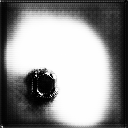

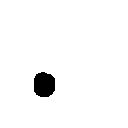

In [ ]:
cv2_imshow(p_list[0])
cv2_imshow(x[0])